# pca autoencoder

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from autoencoder.clock import get_dataloaders

# PCA Autoencoder

class PCAAutoencoder:
  def __init__(self, n_components):
    self.n_components = n_components
    self.pca = PCA(n_components=n_components)
    self.mean = None

  def fit(self, X):
    self.mean = np.mean(X, axis=0)
    X_centered = X - self.mean
    self.pca.fit(X_centered)
    
  def encoder(self, X):
    X_centered = X - self.mean
    return self.pca.transform(X_centered)
  
  def decoder(self, Z):
    X_reconstructed = self.pca.inverse_transform(Z)
    return X_reconstructed + self.mean


In [3]:
dataloader, _, _, _ = get_dataloaders(batch_size=4096, val_size=0, data_size=4096)
imgs = next(iter(dataloader))[0]
print(imgs.shape)

torch.Size([4096, 1, 128, 128])


(4096, 2)
(4096, 16384)


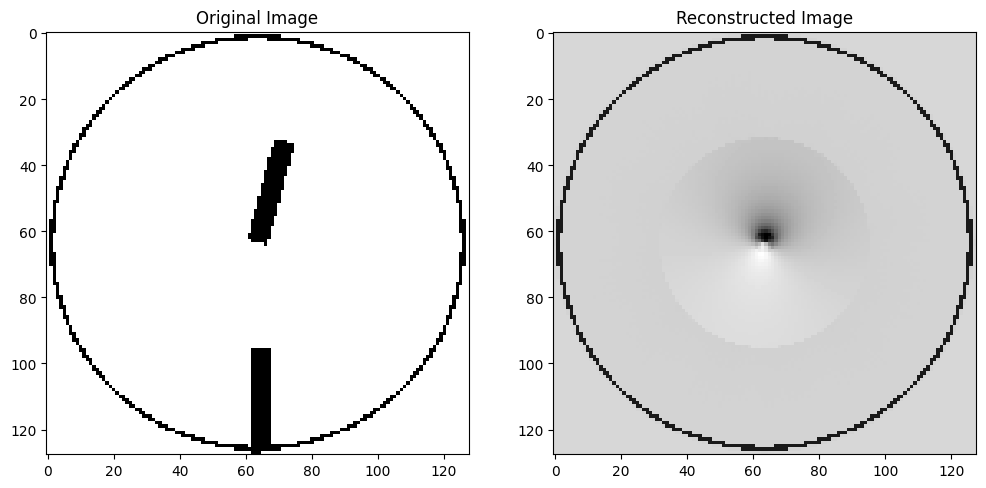

Text(0, 0.5, 'Principal Component 2')

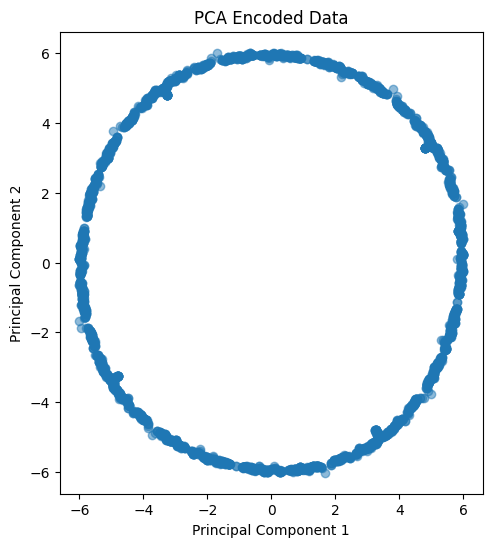

: 

In [ ]:
pca = PCAAutoencoder(n_components=2)
imgs = imgs.reshape(imgs.shape[0], -1)
pca.fit(imgs.numpy())

# Encode
Z = pca.encoder(imgs.numpy())
print(Z.shape)
# Decode
X_reconstructed = pca.decoder(Z)
print(X_reconstructed.shape)

idx = np.random.randint(0, imgs.shape[0])

# Plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(imgs[idx].reshape(128, 128), cmap='gray')
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(X_reconstructed[idx].reshape(128, 128), cmap='gray')
plt.title('Reconstructed Image')
plt.show()
# Plot PCA components
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Z[:, 1], alpha=0.5)
plt.title('PCA Encoded Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

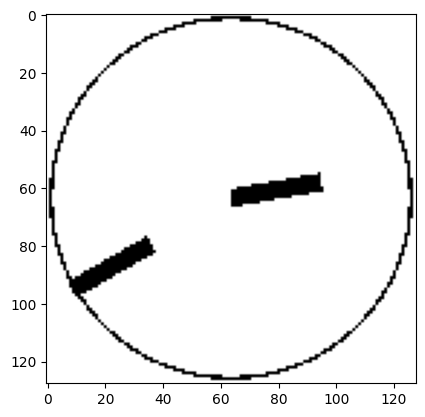

: 

In [6]:
import torch
from dataclasses import dataclass
from datasets.clock import ClockGenerator, ClockConfig, ClockDataset
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE=128

dataset = ClockDataset()

img = dataset.generator.generate_clock_tensor(torch.tensor(2), torch.tensor(40))

plt.imshow(img[0].cpu().numpy(), cmap='gray')


In [1]:
import functools
import numpy as np
import torch.nn as nn
import torch

from models.decoders import ConvResidualDecoderBlock 

class C:
  
  def __init__(self, a=0, b=0, c=0):
    self.a = a
    self.b = b
    self.c = c
    

args = dict(c=3)
c = functools.partial(C, a=1, b=2, **args)

print(c())  


class ConvResidualDecoderBlock3d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size=4, stride=2, padding=1, dilation=1):
        super(ConvResidualDecoderBlock3d, self).__init__()
        
        self.upsample1 = nn.Sequential(
          nn.ConvTranspose3d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation),
          nn.BatchNorm3d(out_planes),
          nn.LeakyReLU(),
          nn.Conv3d(out_planes, out_planes, kernel_size=3, stride=1, padding=padding, dilation=dilation),
          nn.BatchNorm3d(out_planes),
          nn.LeakyReLU()
        )
        
        self.upsample2 = nn.Sequential(
          nn.ConvTranspose3d(out_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation),
          nn.BatchNorm3d(out_planes),
          nn.LeakyReLU(),
          nn.Conv3d(out_planes, out_planes, kernel_size=3, stride=1, padding=padding, dilation=dilation),
          nn.BatchNorm3d(out_planes),
          nn.LeakyReLU()
        )

        self.skip = nn.Sequential(
            nn.Conv3d(in_planes, out_planes, kernel_size=1, stride=1),
            nn.Upsample(scale_factor=stride**2, mode='nearest'),
            nn.BatchNorm3d(out_planes),
            nn.LeakyReLU()
        )

    def forward(self, x):
        identity = self.skip(x)
        out = self.upsample1(x)
        out = self.upsample2(out)
        out += identity
        return out

img_size = 128
latent_dim=2
dim_before_conv = (2 * img_size) // 128
resnet_start_channels = 128
resnet_start_planes = 64

dim_before_3dconv = 8


fc = nn.Sequential(
    nn.Linear(latent_dim, resnet_start_planes*dim_before_3dconv * dim_before_conv**2), # 2x2 -> 8x8
    nn.ReLU(),
    nn.Unflatten(1, (resnet_start_planes, dim_before_3dconv, dim_before_conv, dim_before_conv)), # 8x8 -> 32x32
)

decoder3d_conv = nn.Sequential(
    ConvResidualDecoderBlock3d(resnet_start_planes, resnet_start_planes // 2),  # 2x2 -> 8x8
    nn.Dropout(0.3),
    ConvResidualDecoderBlock3d(resnet_start_planes // 2, 1),  # 8x8 -> 32x32
    nn.Dropout(0.3),
    nn.Flatten(start_dim=1, end_dim=2),
    nn.ReLU()
)

decoder_conv = nn.Sequential(
    ConvResidualDecoderBlock(resnet_start_channels, resnet_start_channels // 1, convt_strides=[1,1]), #
    nn.Dropout(0.3),
    ConvResidualDecoderBlock(resnet_start_channels // 1, resnet_start_channels // 2, convt_strides=[1,1], dilation=1),  #
    nn.Dropout(0.3),
    ConvResidualDecoderBlock(resnet_start_channels // 2, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.2),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.1),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.1),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.1),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.04),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 4, convt_strides=[1,1], dilation=1),  # 
    nn.Dropout(0.01),
    ConvResidualDecoderBlock(resnet_start_channels // 4, resnet_start_channels // 16, convt_strides=[1,1], dilation=1),  # 

    ConvResidualDecoderBlock(resnet_start_channels // 16, resnet_start_channels // 16, convt_strides=[2,2], dilation=1),  #

    nn.Conv2d(resnet_start_channels // 16, 1, kernel_size=3, stride=1, padding=1), # 128x128 -> 128x128
    nn.ReLU()
)

input = torch.randn(64, 2)
out = fc(input)
out = decoder3d_conv(out)
out = decoder_conv(out)

out.shape


torch.Size([64, 1, 128, 128])

: 

In [2]:
from autoencoder.vis import print_model_parameters
from models.decoders import ResNetDecoder3, ResNetDecoder2
from models.encoders import ConvMLPEncoder
from models.autoencoders import MLPResnetAutoencoder
import torch
from functools import partial

# for fc_size, resnet_start_channels in [[8192, 16], [4096, 32], [1900, 64], [600, 128], [180, 256], [100, 384]]:
#     model = partial(ResNetDecoder3,
#       latent_dim=2, 
#       img_size=128, 
#       resnet_start_channels=resnet_start_channels,
#       fc_size=fc_size,
#     )

#     print_model_parameters(
#       model
#     )
    
    

model = partial(MLPResnetAutoencoder,
  latent_dim=2, 
  img_size=128, 
  encoder_args=dict(
    fc_size=512,
  ),
  decoder_args=dict(
    resnet_start_channels=384,
    fc_size=1024,
    conv_start_channels=64,
  ),
)

print_model_parameters(
  model,
  details=True
)

Layer                                       Param Count
------------------------------------------------------------
encoder.conv.0.downsample1.0.weight                 144
encoder.conv.0.downsample1.0.bias                    16
encoder.conv.0.downsample1.1.weight                  16
encoder.conv.0.downsample1.1.bias                    16
encoder.conv.0.downsample1.4.weight                2304
encoder.conv.0.downsample1.4.bias                    16
encoder.conv.0.downsample1.5.weight                  16
encoder.conv.0.downsample1.5.bias                    16
encoder.conv.0.downsample2.0.weight                2304
encoder.conv.0.downsample2.0.bias                    16
encoder.conv.0.downsample2.1.weight                  16
encoder.conv.0.downsample2.1.bias                    16
encoder.conv.0.downsample2.4.weight                2304
encoder.conv.0.downsample2.4.bias                    16
encoder.conv.0.downsample2.5.weight                  16
encoder.conv.0.downsample2.5.bias          

torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])
torch.Size([4, 1, 128, 128])


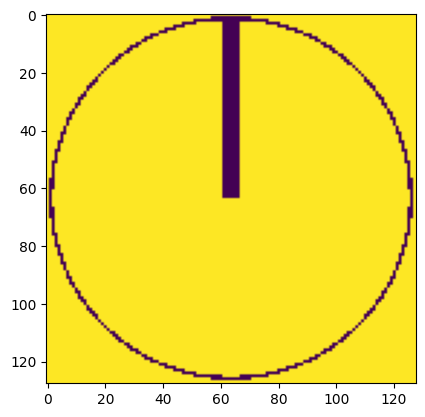

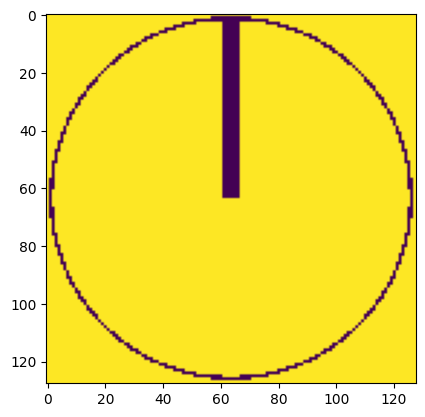

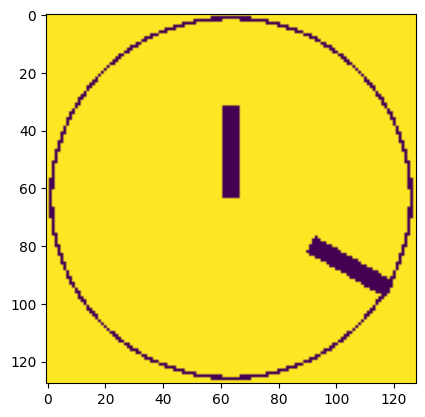

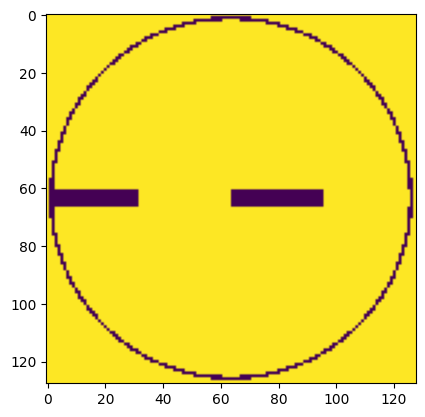

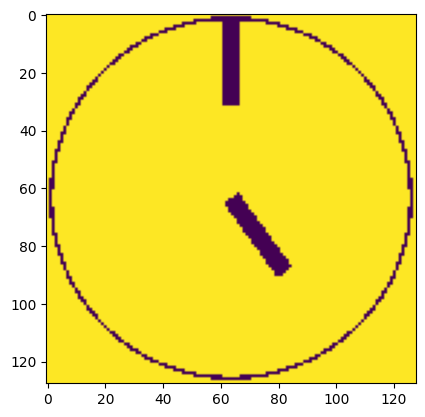

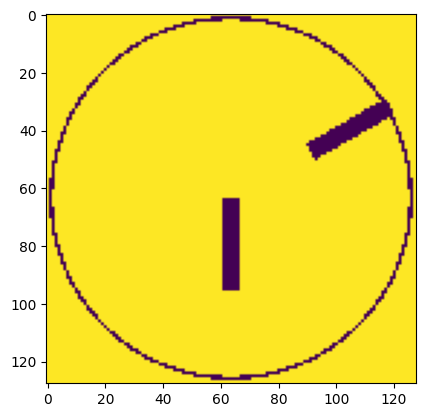

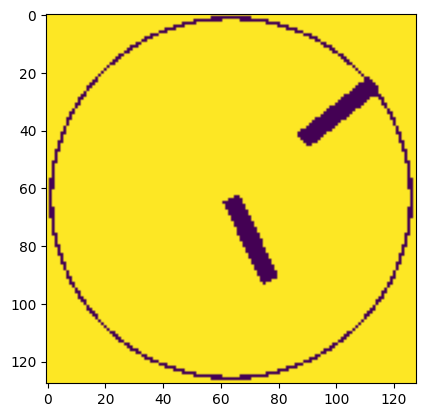

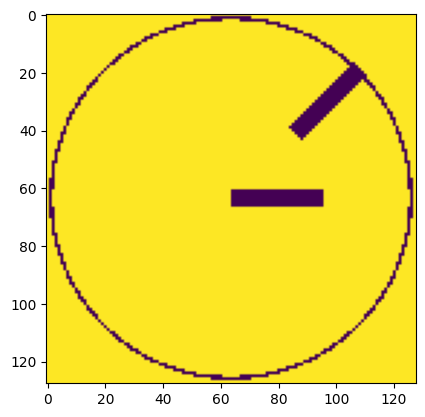

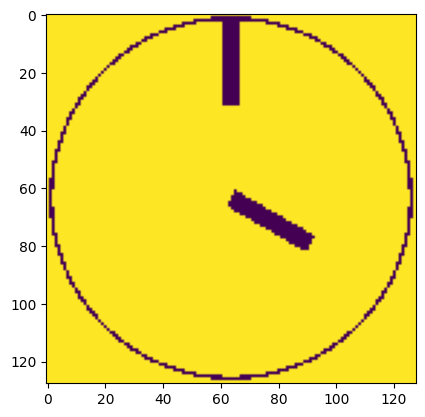

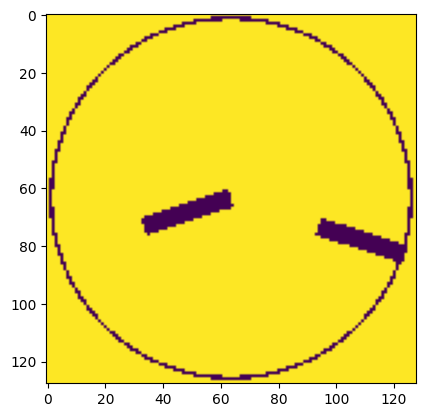

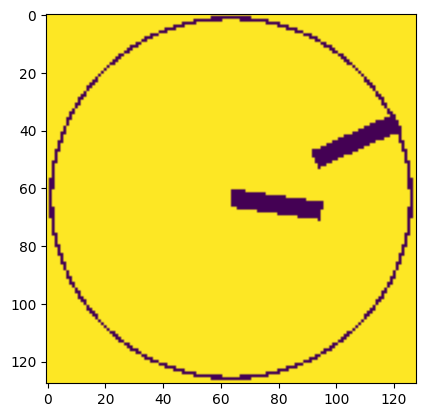

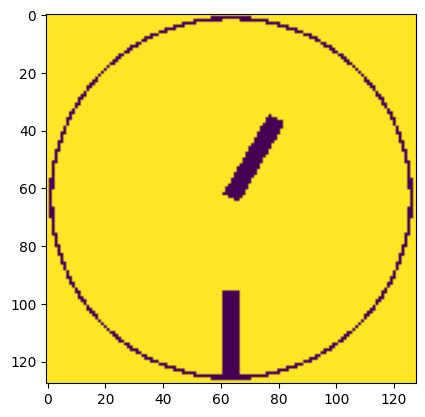

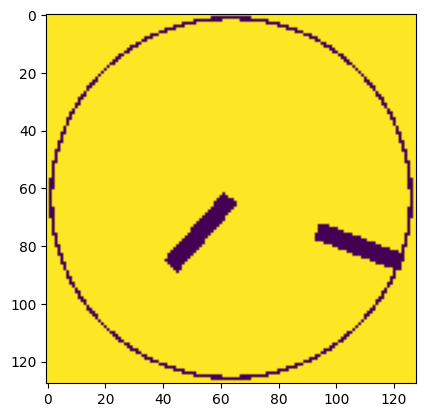

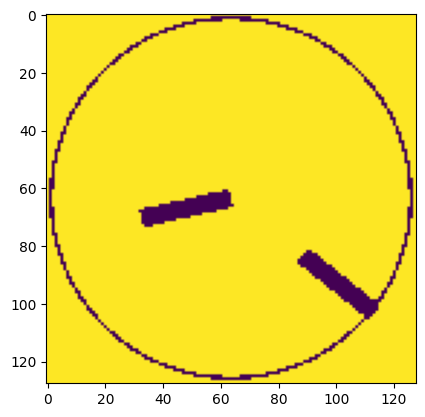

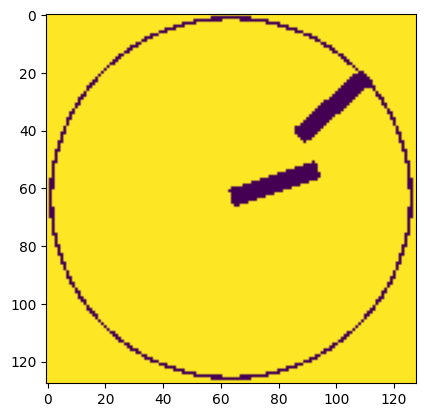

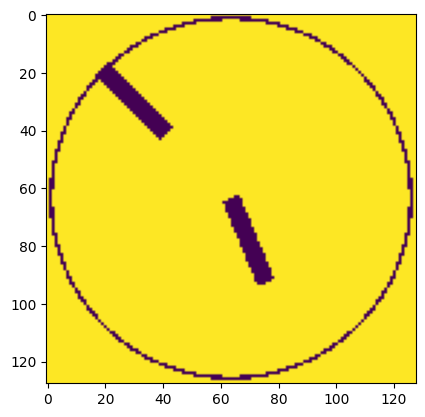

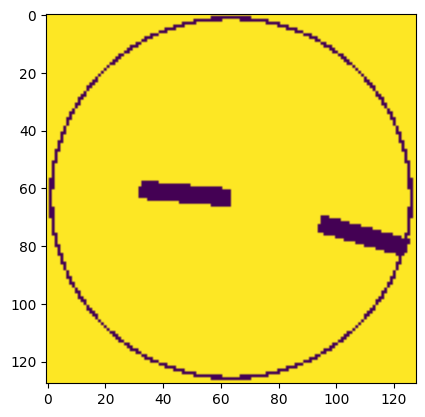

: 

In [ ]:
from datasets.clock import ClockDatasetConfig, ClockGenerator, ClockConfig, ClockDataset
from autoencoder.clock import get_dataloaders
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch

dl, _, _, _ = get_dataloaders(
  batch_size=4, 
  val_size=0, 
  data_size=4096,
  data_config=ClockConfig(
    angle_quantization=1,
  ),
  dataset_config=ClockDatasetConfig(
    augment=dict(
      blur=4
    )
  ),
  use_workers=False,
)

dataset = dl.dataset

# dataset = ClockDataset(
#   config=ClockConfig(
#     angle_quantization=1,
#   ),
#   img_size=128,
#   len=1024
# )

# sampler = torch.utils.data.RandomSampler(dataset)

# dl = DataLoader(dataset, batch_size=4, sampler=sampler, pin_memory=True, drop_last=True, num_workers=0, prefetch_factor=None, persistent_workers=False)

for i, batch in enumerate(dl):
  
  print(batch[0].shape)
  plt.figure()
  plt.imshow(batch[0][0].squeeze().cpu(), cmap='gray')
  dl.dataset.dataset.generator.config.angle_quantization += 1
  
  if i >= 16:
    break
  

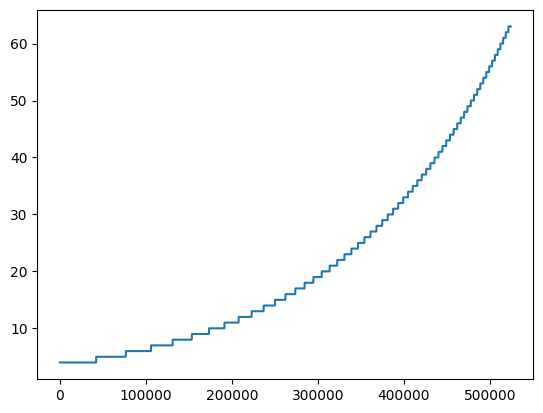

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def scheduler(idx: int, alpha=17, beta=2):
  """
  scheduler
  """
  return int(2**(beta+idx*2**(-1*alpha))) if idx<2**(alpha+2) else None

# plot scheduler from 0 to 2**21
x = np.arange(0, 2**22, 100)
y = [scheduler(i) for i in x]

plt.plot(x, y)
plt.show()

In [78]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import functools

def f(x, slope=1e5):
  
  mean = -3 * torch.tensor(x/slope).sigmoid()
  return np.random.lognormal(mean, 0.05)

f_ = functools.partial(f, slope=1e5)

f_(2**17)

0.09328143330969123